# Clipping Rio Grande Riparian Zones

In [1]:
# Import Packages
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import json
import requests
import time
from requests.auth import HTTPBasicAuth
from osgeo import gdal
import subprocess
import datetime
import xarray as xr
import rioxarray as rxr
import pandas as pd
import geopandas as gp
import pathlib
from planet import Session, DataClient, OrdersClient
import geojsonio
import shutil
import rasterio.plot as show
import contextily as cx
print("packages loaded.")

packages loaded.


In [2]:
# Read in the River Shapefile
filename = "Better_flowline.shp"
filepath = os.path.join('Data/Shapefiles/', filename)
river = gp.read_file(filepath)

Visualize with a basemap to make sure it's in the right place

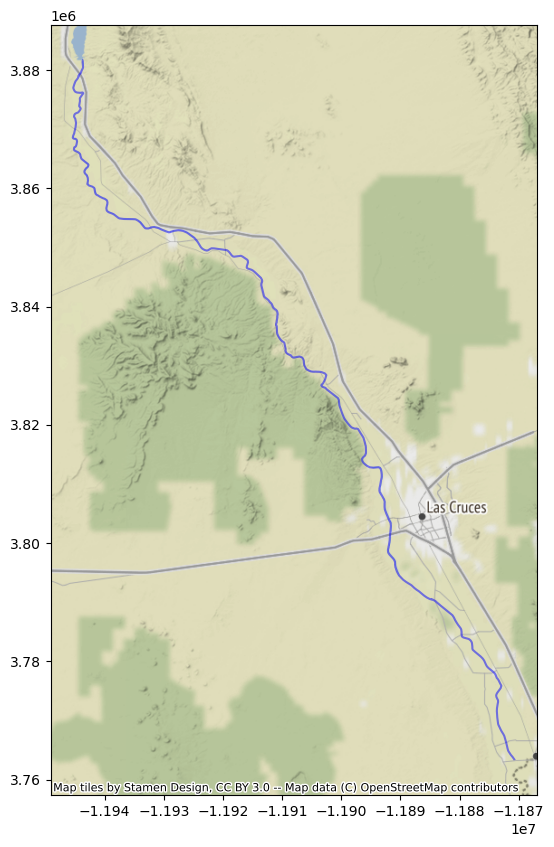

In [3]:
river_wm = river.to_crs(3857)
ax = river_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor="b")
cx.add_basemap(ax)

Creating the area round the monitoring well and putting it in the correct cooridinate system

The cooridnate system is  +init=epsg:3857 +type=crs
Total area (km^2):  0    6.857272
Name: area, dtype: float64


/Users/danielletadych/opt/miniconda3/envs/planet/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


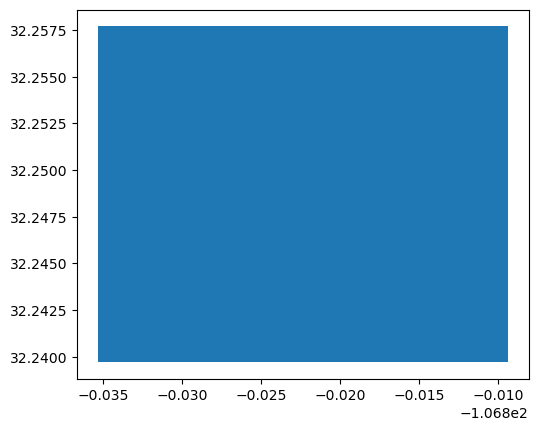

In [22]:
# Site Coordinates
site_name = 'MES_48R'
longitude = -106.8223400
latitude = 32.2486900

# # MES_15R
# site_name = 'MES_15R'
# longitude = -106.8482815 # x
# latitude = 32.3510906 # y

# # RIN_2R
# site_name = 'RIN_2R'
# longitude = -107.2416600
# latitude = 32.7076400

# # RIN_9R
# site_name = 'RIN_9R'
# longitude = -107.2647500 
# latitude = 32.7466600


# Buffer
buffer_lat = 0.009
buffer_lon = 0.013

wells= pd.DataFrame(
    {
        "Site_Name":[site_name],
        "Latitude":[latitude],
        "Longitude":[longitude]
    }
)

wells_gdf = gp.GeoDataFrame(wells,geometry=gp.points_from_xy(wells.Longitude,wells.Latitude,crs="4326"))
wells_gdf = wells_gdf.to_crs("3857")

study_area = {"type":"MultiPolygon",
              "coordinates":[[
        [
            [(longitude+buffer_lon),(latitude-buffer_lat)], #left, bottom
            [(longitude+buffer_lon),(latitude+buffer_lat)], #left, top
            [(longitude-buffer_lon),(latitude+buffer_lat)], #right, top
            [(longitude-buffer_lon),(latitude-buffer_lat)], #right, bottom
            [(longitude+buffer_lon),(latitude-buffer_lat)] #left, bottom
         ]
         ]]}

# site_name = 'test'
with open('AOI/'+site_name+'.json', 'w', encoding='utf-8') as f:
    json.dump(study_area, f, ensure_ascii=False, indent=4)

gdf = gp.read_file('AOI/'+site_name+'.json')
gdf.plot()

tost = gdf.copy()
tost= tost.to_crs({'init': 'epsg:3857'})
print("The cooridnate system is ",tost.crs)
tost["area"] = tost['geometry'].area/ 10**6
print("Total area (km^2): ",tost['area'])

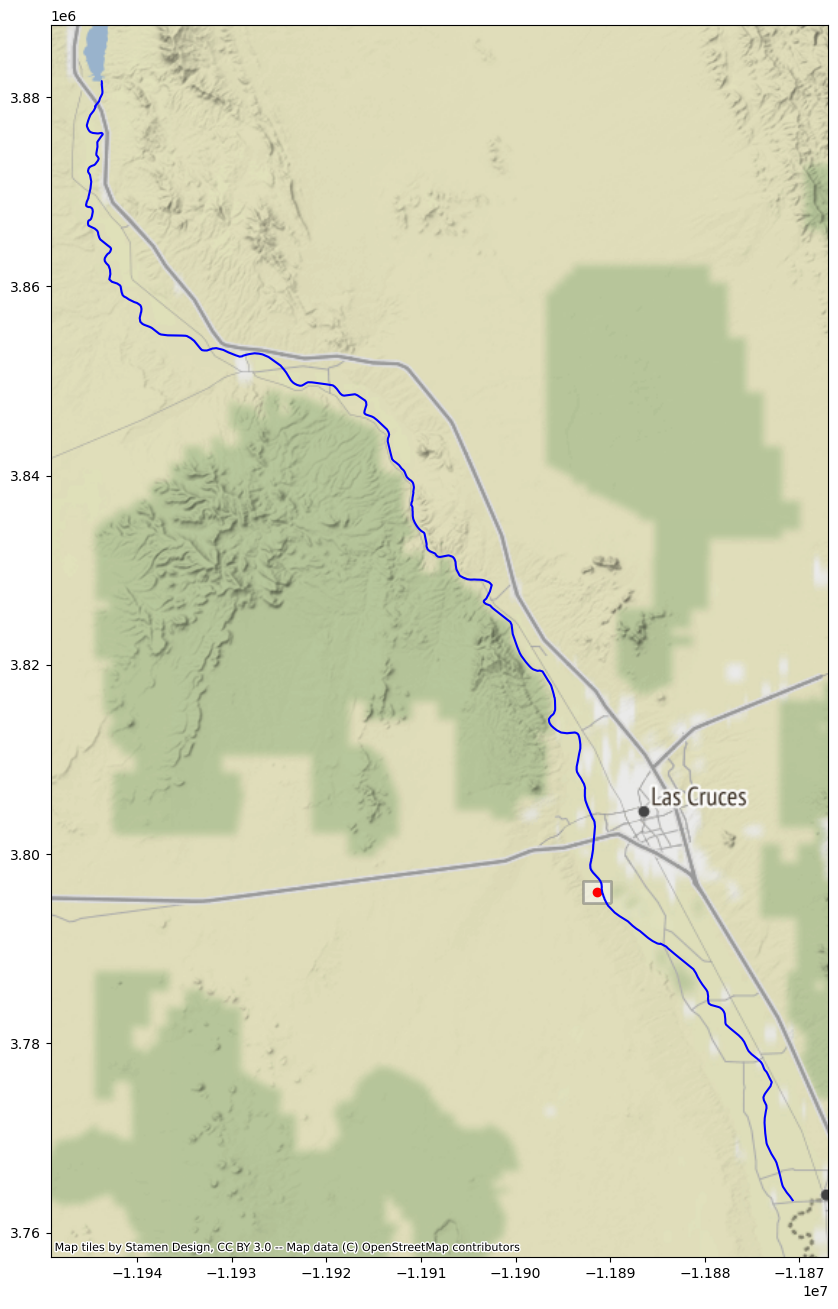

In [23]:
# ax = tost.plot(figsize=(10, 10), alpha=0.5, edgecolor="b")
# river_wm.plot()

fig, ax = plt.subplots(figsize=(16, 16))

tost.plot(ax=ax, color='#ffffff', alpha=0.5, edgecolor='#6a6a6a', linewidth=2)
wells_gdf.plot(ax=ax,color='r')
river_wm.plot(ax=ax, color='b')
cx.add_basemap(ax)

Clipping the River to just close to our monitor well

HTTPError: Tile URL resulted in a 404 error. Double-check your tile url:
https://stamen-tiles-a.a.ssl.fastly.net/terrain/16/13318/26558.png

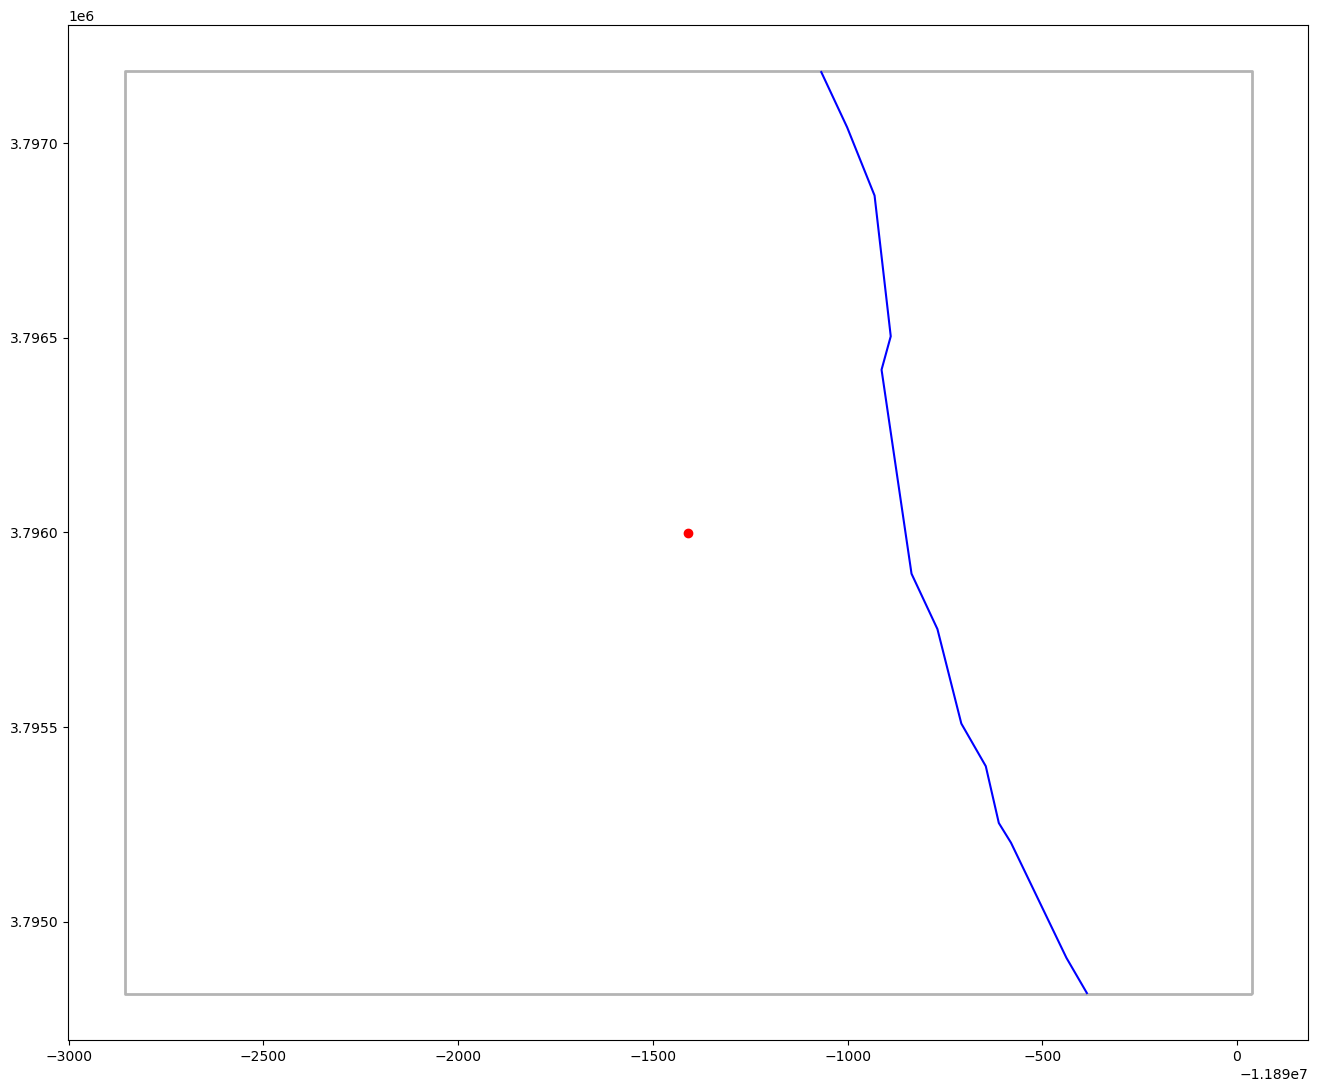

In [24]:
river_clip = gp.clip(river_wm,tost)
fig, ax = plt.subplots(figsize=(16, 16))

tost.plot(ax=ax,color='#ffffff', alpha=0.5, edgecolor='#6a6a6a', linewidth=2)
wells_gdf.plot(ax=ax,color='r')
river_clip.plot(ax=ax, color='b')
cx.add_basemap(ax)

Set the distance for the riparian zone around the river.  From the map we can see where roads are located, which line agricultural fields, so we want as little overlap as possible.

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_75809/2391988555.py:10: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


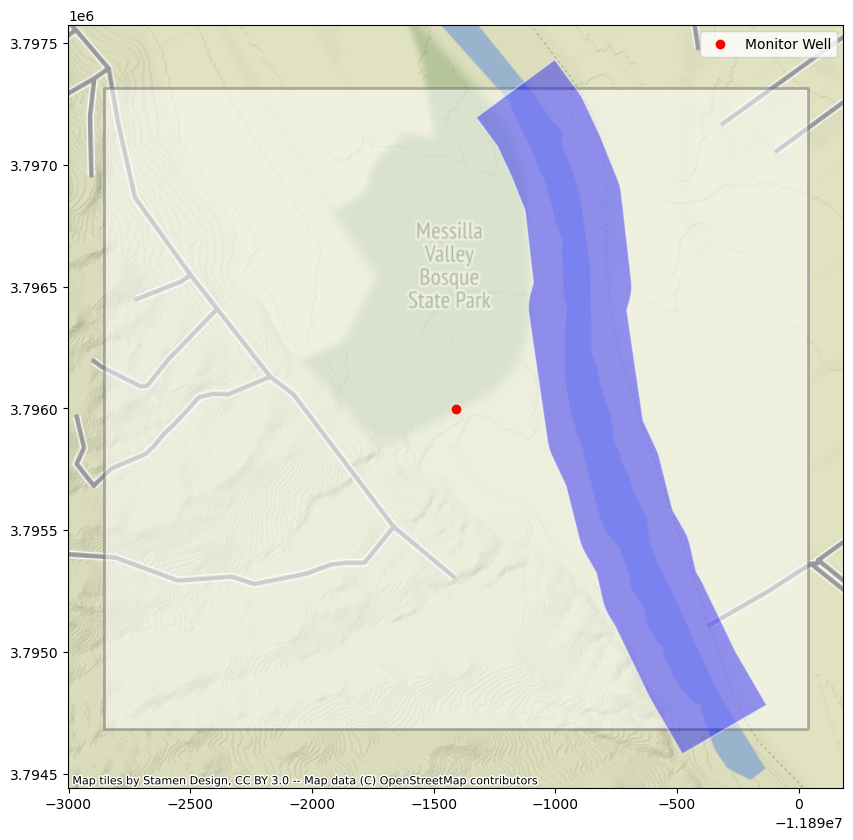

In [6]:
# set buffering distance (meters)
distance = 200
river_buffer = river_clip.buffer(distance,cap_style=2)

fig, ax = plt.subplots(figsize=(10, 10))

tost.plot(ax=ax, color='#ffffff', alpha=0.5, edgecolor='#6a6a6a', linewidth=2)
wells_gdf.plot(ax=ax,color='r',label="Monitor Well")
river_buffer.plot(ax=ax, color='b',alpha = 0.4,edgecolor='#FFFFFF',label="AOI")
ax.legend()
cx.add_basemap(ax)


Change the coordinate system to one with lat/lon

<Axes: >

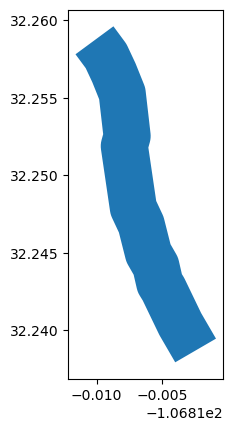

In [7]:
converted = river_buffer.to_crs(4326)
converted.plot()

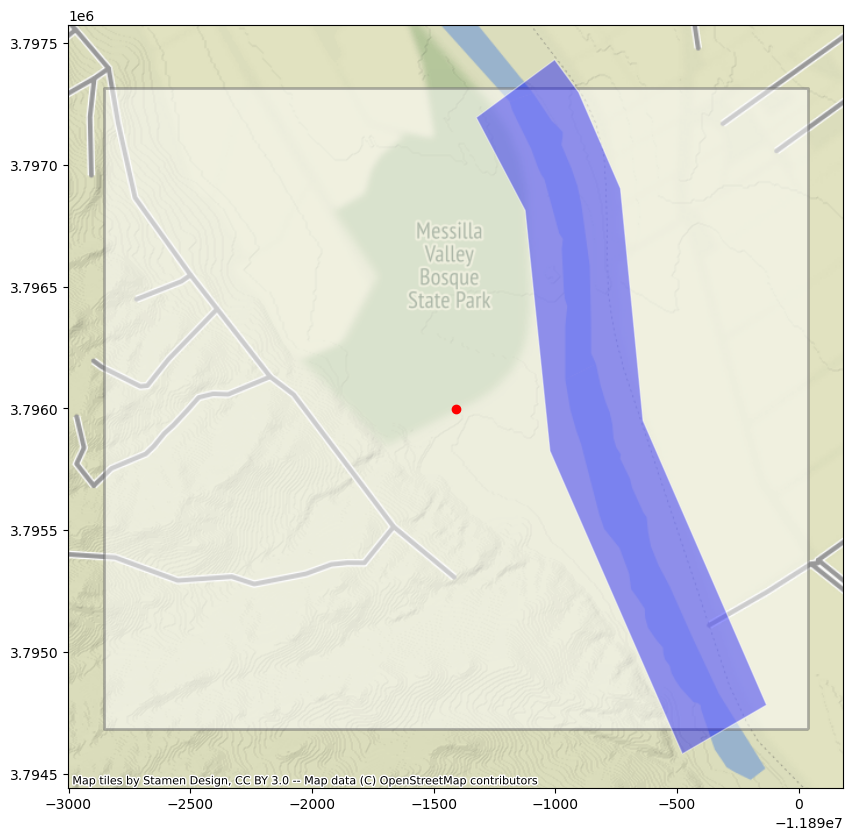

In [8]:
# Making it not so complicated of a polygon
simplified = converted.simplify(0.0006)

visualize_simplify = simplified.to_crs(3857)

fig, ax = plt.subplots(figsize=(10, 10))
tost.plot(ax=ax, color='#ffffff', alpha=0.5, edgecolor='#6a6a6a', linewidth=2)
wells_gdf.plot(ax=ax,color='r',label="Monitor Well")
visualize_simplify.plot(ax=ax, color='b',alpha = 0.4,edgecolor='#FFFFFF',label="AOI")
# ax.legend()
cx.add_basemap(ax)

In [9]:
simplified

0    POLYGON ((-106.81783 32.25858, -106.81629 32.2...
dtype: geometry

Save the file

In [88]:
with open('AOI/'+site_name+'_riverbuffer.geojson' , 'w') as file:
    file.write(simplified.to_json())

In [10]:
type(simplified)

geopandas.geoseries.GeoSeries

In [14]:
# Write shapefile for later

simplified.to_file('AOI/'+site_name+'_simplified.shp')

In [21]:
tost.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

/var/folders/7k/m9jgv50j0qv046r7xmwxt0qh0000gn/T/ipykernel_75809/663741636.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3857
Right CRS: EPSG:4326

  simplified_clip = gp.clip(tost,simplified)
/Users/danielletadych/opt/miniconda3/envs/planet/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


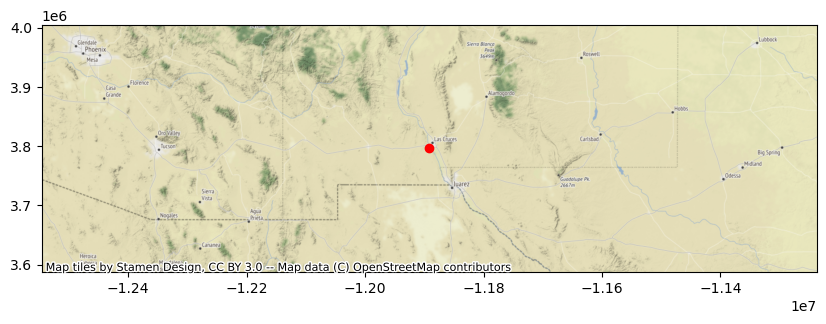

In [18]:
simplified_clip = gp.clip(tost,simplified)

visualize_simplify = simplified_clip.to_crs(3857)

fig, ax = plt.subplots(figsize=(10, 10))
# simpl.plot(ax=ax, color='#ffffff', alpha=0.5, edgecolor='#6a6a6a', linewidth=2)
wells_gdf.plot(ax=ax,color='r',label="Monitor Well")
visualize_simplify.plot(ax=ax, color='b',alpha = 0.4,edgecolor='#FFFFFF',label="AOI")
# ax.legend()
cx.add_basemap(ax)